<a href="https://colab.research.google.com/github/kittimaxz/Project_BoneAge/blob/main/faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is an attempt to predict bone age using Xception(pre trained model)

In [150]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra # เป็นการ import numpy เพื่อเปิดใช้ฟังก์ชันในการทำงาน
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) # เป็น library ในการจัดการ dataframe
import tensorflow as tf #library สำหรับสร้าง machine learning models แบบ open source จาก Google
import datetime,os # datetime ใช้ในการจัด format ของวัน-เวลาให้อยู่ในรูปแบบที่ต้องการ 
import math # เรียกใช้ module เพื่อคำนวณค่าต่างๆ 
import matplotlib.pyplot as plt # เป็น module พื้นฐานที่ใช้ในการสร้างกราฟของ python
import seaborn as sns # เป็นฟังก์ชันเสริมที่ใช้สร้างกราฟให้มีความสวยงามมากขึ้น
from sklearn.model_selection import train_test_split # เป็น library ในการพัฒนาโปรแกรมโดยใช้การเรียนรู้ของเครื่อง

In [151]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์

In [153]:
path = '/content/drive/My Drive/Project_Boneage'  # ชี้ว่า data เราอยู่โฟล์เดอร์ไหน

# ***Some Setup***

The cell below creates the pandas dataframes for training and testing.

In [154]:
#loading dataframes # เอาที่อยู่ของไฟล์เชื่อมกับที่อยู่ของไฟล์เรา โดยกำหนดชื่่อไฟล์ที่เราต้องการ
train_path = os.path.join(path,'boneage-training-dataset_5261.csv')
train_df = pd.read_csv(train_path)
test_path = os.path.join(path,'boneage-test-dataset-200.csv')
test_df = pd.read_csv(test_path)

In [155]:
train_df # แสดง data 'train_df'

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False
...,...,...,...
5256,7399,168,True
5257,7402,156,True
5258,7403,94,False
5259,7404,150,True


In [156]:
test_df # แสดง data 'test_df'

,id,boneage,male
0,15383,96,True
1,15384,150,True
2,15385,168,True
3,15386,69,False
4,15387,150,True
...,...,...,...
195,15605,50,False
196,15606,113,False
197,15608,55,False
198,15609,150,True


In [157]:
#appending file extension to id column for both training and testing dataframes
# ต่อท้าย data ใน column 'id' ด้วย .png
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png') # ทำการเปลี่ยน type ใน column 'id' จาก int  เป็น string เพื่อให้สามารถต่อท้ายด้วย .png ได้ # ฟังก์ชันแลมบ์ดาเป็นฟังก์ชันที่ไม่ระบุตัวตนขนาดเล็ก
test_df['id'] = test_df['id'].apply(lambda x: str(x)+'.png') 

train_df.head() # แสดงค่าของ train_df บางส่วน

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


# Some EDA and feature engineering follow

In [158]:
#finding out the number of male and female children in the dataset
#creating a new column called gender to keep the gender of the child as a string
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female') # ทำการเปลี่ยนค่าข้อมูล gender จาก true -> male, false -> female 
train_df['gender']

0       female
1       female
2       female
3         male
4       female
         ...  
5256      male
5257      male
5258    female
5259      male
5260      male
Name: gender, Length: 5261, dtype: object

In [159]:
test_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female') # ทำการเปลี่ยนค่าข้อมูล gender จาก true -> male, false -> female 
test_df['gender']

0      female
1      female
2      female
3        male
4      female
        ...  
195      male
196      male
197    female
198      male
199    female
Name: gender, Length: 200, dtype: object

In [160]:
print(train_df['gender'].value_counts()) #แสดงจำนวนเพศหญิงและเพศชายทั้งหมดใน trian_df

male      2870
female    2391
Name: gender, dtype: int64


In [161]:
train_df.shape # ข้อมูลมีทั้งหมด 261 จากทั้งหมด 4 column

(5261, 4)

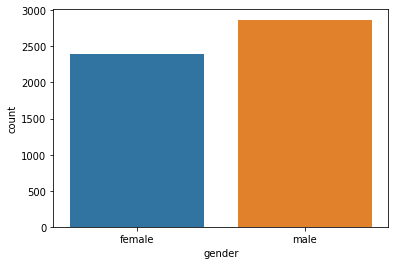

In [162]:
sns.countplot(x = train_df['gender']) # plot กราฟแสดงจำนวนเพศหญิงและเพศชายทั้งหมดใน trian_df

In [163]:
#oldest child in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months') # ทำการหาอายุที่มากที่สุด และทำการต่อท้ายด้วย months

MAX age: 228 months


In [164]:
#youngest child in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')  # ทำการหาอายุที่น้อยที่สุด และทำการต่อท้ายด้วย months

MIN age: 1 months


In [165]:
#mean age is # หาค่าเฉลี่ยอายุกระดูก
mean_bone_age = train_df['boneage'].mean() 
print('mean: ' + str(mean_bone_age))

mean: 128.2655388709371


In [166]:
#median bone age # หาค่า median ของอายุกระดูก
print('median: ' +str(train_df['boneage'].median()))

median: 132.0


In [167]:
#standard deviation of boneage # หาค่าส่วนเบี่ยงเบนมาตรฐานของอายุกระดูก
std_bone_age = train_df['boneage'].std()
std_bone_age

43.490998243020265

In [168]:
#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training 
# ทำการหาค่า z-score 
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)
print(train_df.head())

         id  boneage   male  gender  bone_age_z
0  1377.png      180  False  female    1.189544
1  1378.png       12  False  female   -2.673324
2  1379.png       94  False  female   -0.787877
3  1380.png      120   True    male   -0.190052
4  1381.png       82  False  female   -1.063796


Text(0.5, 1.0, 'Number of children in each age group')

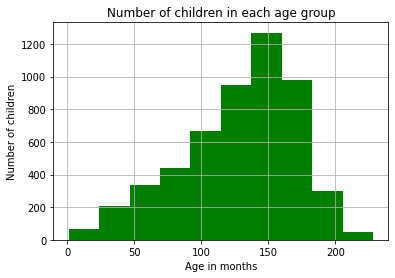

In [169]:
#plotting a histogram for bone ages # plot กราฟ เพื่อดูการกระจายของอายุกระดูก
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')

Text(0.5, 1.0, 'Relationship between number of children and bone age z score')

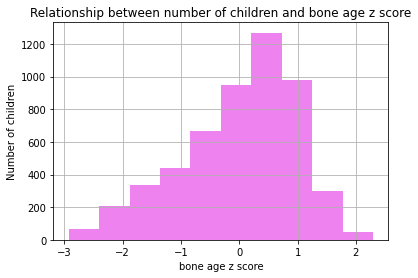

In [170]:
train_df['bone_age_z'].hist(color = 'violet') # plot กราฟ เพื่อดูการกระจายค่า z-score ของอายุกระดูก
plt.xlabel('bone age z score')
plt.ylabel('Number of children')
plt.title('Relationship between number of children and bone age z score')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 70.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 71.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


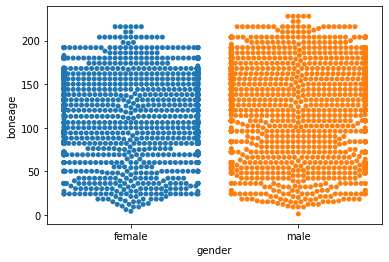

In [171]:
#Relationship between age and gender with a categorical scatter plot (swarmplot) # plot ดูความสัมพันธ์ระหว่างอายุและเพศ
# swarmplot ใช้ plot เพื่อดูการกระจายของข้อมูลโดยที่จุดไม่ทับซ้อนกัน
sns.swarmplot(x = train_df['gender'], y = train_df['boneage'])

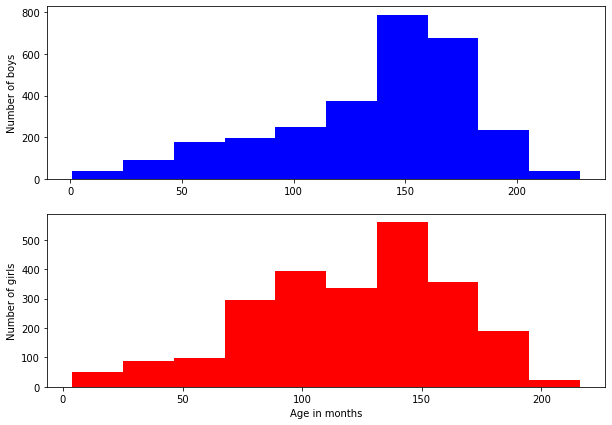

In [172]:
#distribution of age within each gender # plot การกระจายอายุกระดูกของแต่ละเพศ
male = train_df[train_df['gender'] == 'male']
female = train_df[train_df['gender'] == 'female']
fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'blue')
ax[0].set_ylabel('Number of boys')
ax[1].hist(female['boneage'], color = 'red')
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('Number of girls')
fig.set_size_inches((10,7))

In [173]:
#splitting train dataframe into traininng and validation dataframes #แบ่งข้อมูลออกเป็น 2 ส่วน ด้วยการสุ่ม
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0) 
# test_size = 0.2 คือ สัดส่วนของข้อมูลที่ใช้ในการทดสอบ (หากไม่มีการกำหนดค่าจะถูก set = 0.25)# random_state ใช้ในการสุ่มแบ่งกลุ่ม (default=None)

In [174]:
df_train # training

,id,boneage,male,gender,bone_age_z
3240,5171.png,162,False,female,0.775665
1771,3353.png,48,True,male,-1.845567
1921,3521.png,124,True,male,-0.098079
3071,4979.png,108,True,male,-0.465971
771,2238.png,186,True,male,1.327504
...,...,...,...,...,...
4931,7037.png,126,False,female,-0.052092
3264,5198.png,106,False,female,-0.511957
1653,3218.png,165,False,female,0.844645
2607,4273.png,156,False,female,0.637706


In [175]:
df_valid # validation

,id,boneage,male,gender,bone_age_z
1601,3161.png,168,True,male,0.913625
898,2378.png,180,False,female,1.189544
42,1426.png,54,True,male,-1.707607
4587,6648.png,162,True,male,0.775665
567,2015.png,144,False,female,0.361787
...,...,...,...,...,...
5069,7189.png,66,True,male,-1.431688
906,2386.png,150,True,male,0.499746
1489,3033.png,168,True,male,0.913625
4250,6276.png,162,True,male,0.775665


In [176]:
#data_image = os.path.join(path,'boneage-training-dataset') #เอาพาร์ทที่อยู่ในไฟล์มาเชื่อมกับColab
#print(data_image)

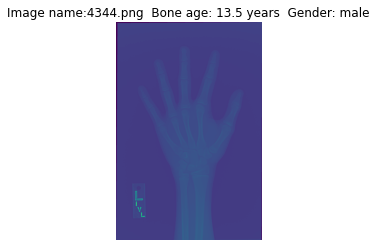

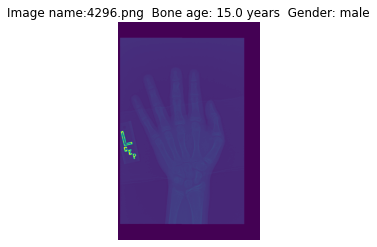

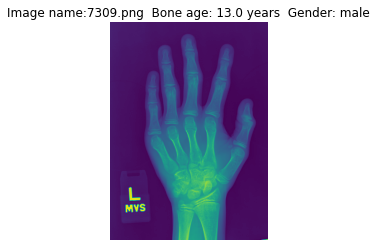

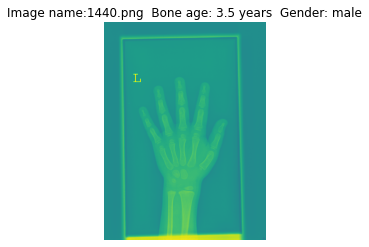

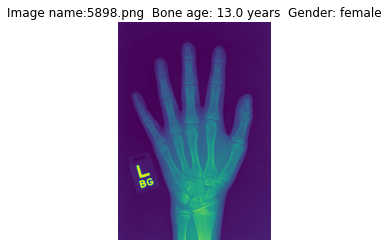

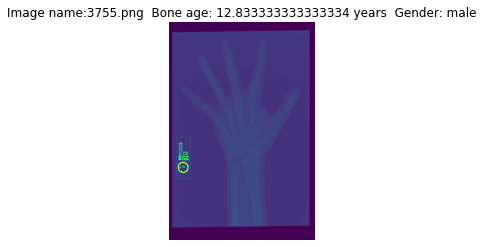

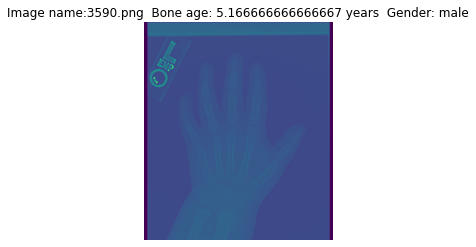

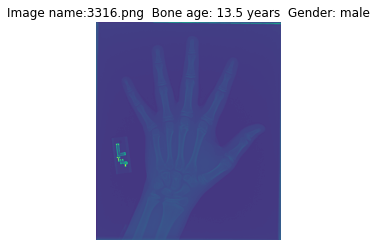

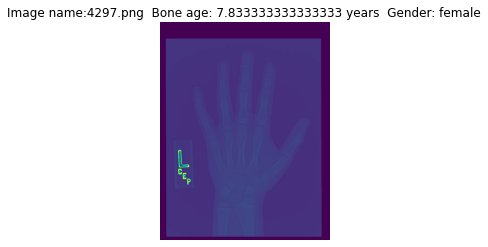

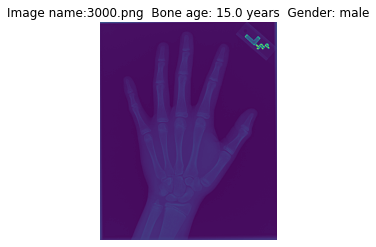

In [177]:
import matplotlib.image as mpimg #นำเข้า library ที่ใช้อ่านรูป
for filename, boneage, gender in train_df[['id','boneage','gender']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ อายุ เพศ)
    img = mpimg.imread(os.path.join(path,'boneage-training-dataset-5261/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.imshow(img) # แสดงรูปภาพ
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.axis('off')
    plt.show()

In [178]:
#library required for image preprocessing 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from  keras.applications.xception import preprocess_input 

In [179]:
#reducing down the size of the image 
img_size = 256 # ลดขนาดรูปภาพ

In [180]:
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [181]:
#train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = (os.path.join(path,'boneage-training-dataset-5261/')),
    x_col= 'id',
    y_col= 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

Found 4208 validated image filenames.


In [182]:
#validation data generator
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = (os.path.join(path,'boneage-training-dataset-5261/')),
    x_col = 'id',
    y_col = 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

Found 1053 validated image filenames.


In [183]:
#test data generator
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    directory = (os.path.join(path,'boneage-test-dataset-200/')),
    target_size = (img_size,img_size),
    shuffle = True,
    class_mode = 'binary',classes=['.'],
    color_mode = 'rgb')

Found 200 images belonging to 1 classes.


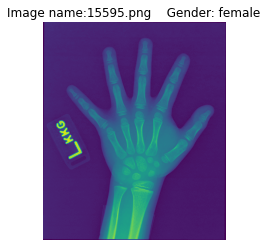

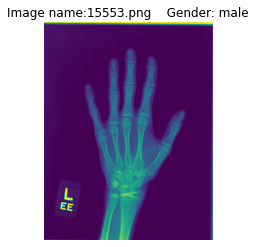

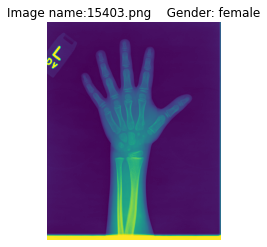

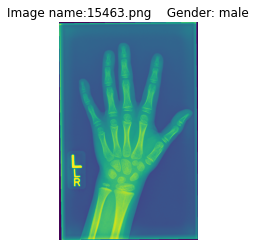

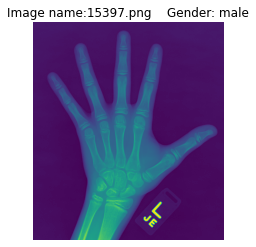

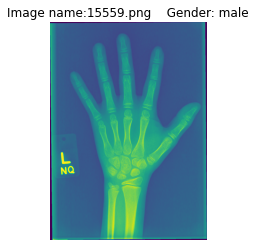

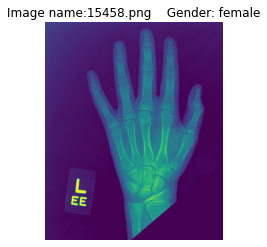

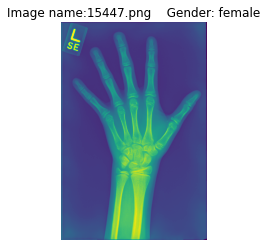

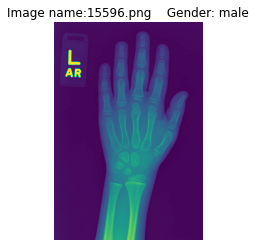

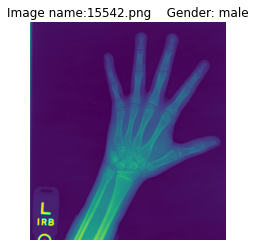

In [184]:
import matplotlib.image as mpimg #นำเข้า library ที่ใช้อ่านรูป
for filename, gender in test_df[['id','gender']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ เพศ)
    img = mpimg.imread(os.path.join(path,'boneage-test-dataset-200/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.imshow(img) # แสดงรูปภาพ
    plt.title('Image name:{}    Gender: {}'.format(filename, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.axis('off')
    plt.show()

In [185]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe( 
                            df_valid, 
                            directory = (os.path.join(path,'boneage-training-dataset-5261/')),
                            x_col = 'id',
                            y_col = 'bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 32,
                            class_mode = 'raw'
                            )) 

Found 1053 validated image filenames.


# Faster R-CNN 

In [239]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import cv2
from xml.etree import ElementTree as et
from matplotlib import patches

In [240]:
class BoneImagesDataset(torch.utils.data.Dataset):

    def __init__(self,image, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = train_df
        self.height = height
        self.width = width
        self.image = dataframe["id"].unique()

        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(train_df))
                        if image[-1:]=='.jpg']

In [241]:
def __getitem__(self, id):

    img_name = self.imgs[id]
    image_path = os.path.join(self.files_dir, img_name)

    # reading the images and converting them to correct size and color    
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
    # diving by 256
    img_res /= 256

In [242]:
for _,row in df_train[df_train.id == "1377.jpg"].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin

In [243]:
rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
ax.add_patch(rect)

NameError: ignored

In [189]:
### Create / load model

#Faster - RCNN Model - pretrained on COCO
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone = False)
#num_classes = 1

#get number of input features for the classifier
#in_features = model.roi_heads.box_predictor.cls_score.in_features

#replace the pre-trained head with a new one
#model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [190]:
### Utilize GPU if available

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#torch.cuda.empty_cache()

In [191]:
#def collate_fn(batch):
    #return tuple(zip(*batch))

#train_dataset = ImageDataGenerator(df_train)
#valid_dataset = ImageDataGenerator(df_valid)

In [192]:
# Train dataset sample
#images,id = next(iter(train_generator))

# The function to plot training and validation error as a function of epochs

In [193]:
#def plot_it(history):
    #'''function to plot training and validation error'''
    #fig, ax = plt.subplots( figsize=(20,10))
    #ax.plot(history.history['mae_in_months'])
    #ax.plot(history.history['val_mae_in_months'])
    #plt.title('Model Error')
    #plt.ylabel('error')
    #plt.xlabel('Epoch')
    #plt.legend(['Train', 'Val'], loc='upper right')
    #ax.grid(color='black')
    #plt.show()

In [194]:
#from keras.metrics import mean_absolute_error
#def mae_in_months(x_p, y_p):
    #'''function to return mae in months'''
    #return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 

In [195]:
#from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten
#from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
#from tensorflow.keras import Sequential


In [196]:
#model_1 = tf.keras.applications.xception.Xception(input_shape = (img_size, img_size, 3),
                                           #include_top = False,
                                           #weights = 'imagenet')
#model_1.trainable = True
#model_2 = Sequential()
#model_2.add(model_1)
#model_2.add(GlobalMaxPooling2D())
#model_2.add(Flatten())
#model_2.add(Dense(10, activation = 'relu'))
#model_2.add(Dense(1, activation = 'linear'))


#compile model
#model_2.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

#model summary
#model_2.summary()

In [197]:
# Load the TensorBoard notebook extension # Tensorflow รองรับกับเครื่องที่
#%load_ext tensorboard
#logs_dir = '.\logs'
#%tensorboard --logdir {logs_dir}

In [198]:
#early stopping
#early_stopping = EarlyStopping(monitor='val_loss',
                              #min_delta=0,
                              #patience= 5,
                              #verbose=0, mode='auto')

In [199]:
#model checkpoint
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
#mc

In [200]:
#tensorboard callback
#logdir = os.path.join(logs_dir,datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
#tensorboard_callback =  TensorBoard(logdir, histogram_freq = 1)
#tensorboard_callback

In [201]:
#reduce lr on plateau
#red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
#red_lr_plat

In [202]:
#callbacks = [tensorboard_callback,early_stopping,mc,red_lr_plat]
#callbacks

In [203]:
#fit model
#history = model_2.fit(train_generator,
                            #steps_per_epoch = 131, # step_per_epoch = train_df/bach_size = 4208/32
                            #validation_data = val_generator,
                            #validation_steps = 1,
                            #epochs = 50,
                            #callbacks= callbacks)
#history
#%tensorboard --logdir logs
#plot_it(history)

# Evaluating the best saved model on the validation data and visualising results!!

In [204]:
#model_2.load_weights('best_model.h5')
#pred = mean_bone_age + std_bone_age*(model_2.predict(test_X, batch_size = 32, verbose = True))
#test_months = mean_bone_age + std_bone_age*(test_Y)

In [205]:
#ord_ind = np.argsort(test_Y)
#ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones
#fig, axs = plt.subplots(4, 2, figsize = (15, 30))
#for (ind, ax) in zip(ord_ind, axs.flatten()):
    #ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    #ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           #pred[ind]/12.0))
    #ax.axis('off')
#fig.savefig('trained_image_predictions.png', dpi = 300)

In [206]:
#fig, ax = plt.subplots(figsize = (7,7))
#ax.plot(test_months, pred, 'r.', label = 'predictions')
#ax.plot(test_months, test_months, 'b-', label = 'actual')
#ax.legend(loc = 'upper right')
#ax.set_xlabel('Actual Age (Months)')
#ax.set_ylabel('Predicted Age (Months)')

# The plot deviates from the line at very old and very young ages probably because we have less examples for those cases in the dataset

Predicting on test data, we obtain:

In [207]:
#test_generator.reset()
#y_pred = model_2.predict(test_generator)
#predicted = y_pred.flatten()
#predicted_months = mean_bone_age + std_bone_age*(predicted)
#filenames=test_generator.filenames
#results=pd.DataFrame({"Filename":filenames,
                      #"Predictions": predicted_months})
#results.to_csv("results.csv",index=False)

In [208]:
#path = '/content/drive/My Drive/Project_Boneage/result_model' 

In [209]:
#predict_path = os.path.join(path,'results_5261img_50epoch.csv')
#predict_df = pd.read_csv(predict_path)

In [210]:
#predict_df

In [211]:
#test_df[['boneage']]

In [212]:
#predict_df[['Predictions']]

In [213]:
#!pip install -U scikit-learn

In [214]:
#from sklearn.metrics import mean_absolute_error

In [215]:
#import sklearn

In [216]:
#MAE = sklearn.metrics.mean_absolute_error(test_df[['boneage']], predict_df[['Predictions']])
#MAE